In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.feature import hog
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 300 images
cnv_subset = cnv.sample(n=400,random_state=42)
normal_subset = normal.sample(n=400,random_state=42)
drusen_subset = drusen.sample(n=400,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)
both=pd.concat([cnv_subset,drusen_subset], ignore_index=True)

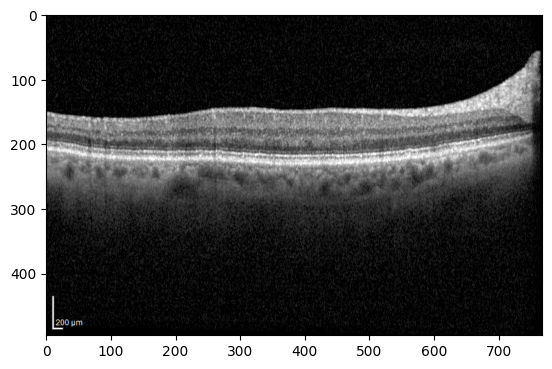

In [ ]:
import cv2
images=[]
for i in drusen['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

# **mean** **filter**

In [ ]:
import os
import cv2

# Load images, apply mean filter, and save the filtered images to a new folder
filtered_images_dir = '/content/drive/MyDrive/Eye/drusenFiltered/'

# Check if the directory exists, and if not, create it
if not os.path.exists(filtered_images_dir):
    os.makedirs(filtered_images_dir)

# Iterate through each row in the DataFrame 'cnv' to process images
for index, row in drusen.iterrows():
    img_path = data_dir + row['Directory']
    img = cv2.imread(img_path)
    if img is not None:
        # Apply mean filter
        filtered_img = cv2.blur(img, (3, 3))  # Adjust kernel size as needed

        # Save the filtered image to the new folder
        filename = os.path.basename(img_path)
        filtered_img_path = os.path.join(filtered_images_dir, filename)
        cv2.imwrite(filtered_img_path, filtered_img)

        print(f"Filtered image saved: {filtered_img_path}")
    else:
        print(f"Error: Unable to read image '{img_path}'")


In [ ]:
filtered_data_dir = '/content/drive/MyDrive/Eye/drusenFiltered/'
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtered/'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in drusen.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

<ipython-input-61-40bbcfa44b9d>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


In [ ]:
# Assuming you have your target vector y as a pandas Series
y = drusen['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'NORMAL': 0, 'DRUSEN': 1})
X =hog_features

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skim

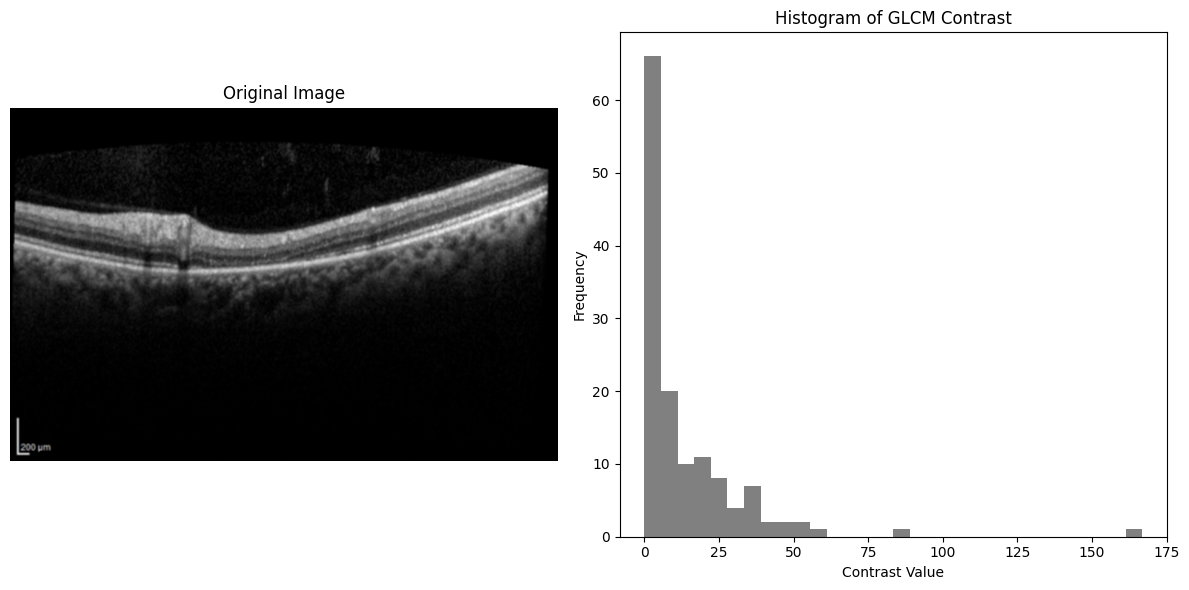

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

def plot_glcm_properties_and_histogram(image_path):
    # Load the original image
    original_img = cv2.imread(image_path)
    if original_img is None:
        print("Image not loaded. Please check the path and file integrity.")
        return

    # Convert to grayscale
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    gray_img = img_as_ubyte(gray_img)  # Ensure the image is in 8-bit, required for greycomatrix

    # Compute GLCM over the whole image for demonstration
    glcm = greycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]

    # Visualization of the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Histogram of Contrast
    # For this part, we will compute contrast for blocks of the image to get a distribution
    block_size = 50
    contrasts = []
    for i in range(0, gray_img.shape[0] - block_size + 1, block_size):
        for j in range(0, gray_img.shape[1] - block_size + 1, block_size):
            block = gray_img[i:i+block_size, j:j+block_size]
            block_glcm = greycomatrix(block, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            block_contrast = greycoprops(block_glcm, 'contrast')
            contrasts.append(block_contrast[0, 0])

    # Plotting histogram of contrasts
    plt.subplot(122)
    plt.hist(contrasts, bins=30, color='gray')
    plt.title('Histogram of GLCM Contrast')
    plt.xlabel('Contrast Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

img_path = '/content/drive/MyDrive/Eye/cnvFiltered/000_CNV.tif'  # Adjust this path

plot_glcm_properties_and_histogram(img_path)


In [ ]:
glcm_features = np.array(glcm_features)

# Display the shape of HOG features
print("Shape of glcm features:", glcm_features.shape)

Shape of glcm features: (800, 5)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.86875 0.8     0.78125 0.81875 0.78125]
Mean Accuracy: 0.8100000000000002


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores with Logistic Regression: [0.85625 0.79375 0.7875  0.8125  0.78125]
Mean Accuracy with Logistic Regression: 0.80625
Standard Deviation of Accuracy with Logistic Regression: 0.027099354235848493


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.7625  0.73125 0.7     0.76875 0.75625]
Mean Accuracy with KNN: 0.7437499999999999
Standard Deviation of Accuracy with KNN: 0.02531057091414575


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.575   0.49375 0.48125 0.60625 0.5625 ]
Mean Accuracy with Naive Bayes: 0.54375
Standard Deviation of Accuracy with Naive Bayes: 0.048250647664046936


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5

# Initialize the SVM classifier
svm_classifier = SVC(kernel='sigmoid')

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_dev_accuracy)

Cross-validation scores: [0.78125 0.69375 0.675   0.70625 0.65   ]
Mean Accuracy: 0.70125
Standard Deviation of Accuracy: 0.04426482802406442


Gamma: 0.001, Mean Accuracy: 0.7787499999999999
Gamma: 0.01, Mean Accuracy: 0.47624999999999995
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47000000000000003
Gamma: 10, Mean Accuracy: 0.47000000000000003


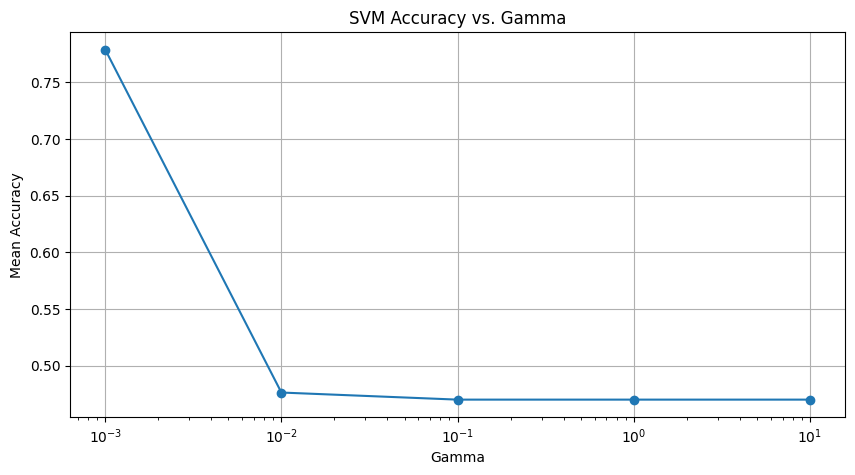

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.84375 0.71875 0.7625  0.76875 0.725  ]
Degree: 1, Mean Accuracy: 0.76375
Degree: 2, Cross-validation scores: [0.83125 0.75625 0.7875  0.8125  0.75   ]
Degree: 2, Mean Accuracy: 0.7875
Degree: 3, Cross-validation scores: [0.80625 0.71875 0.7875  0.7625  0.71875]
Degree: 3, Mean Accuracy: 0.75875
Degree: 4, Cross-validation scores: [0.75    0.68125 0.70625 0.5375  0.6625 ]
Degree: 4, Mean Accuracy: 0.6675000000000001
Degree: 5, Cross-validation scores: [0.58125 0.53125 0.55    0.46875 0.55625]
Degree: 5, Mean Accuracy: 0.5375


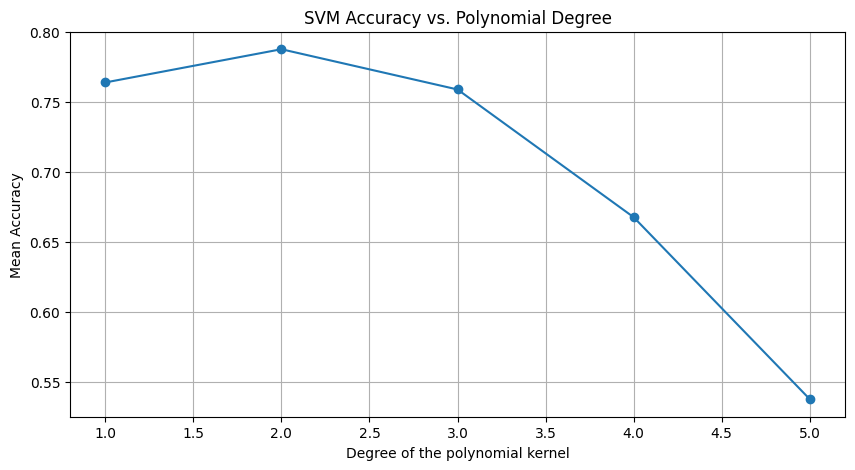

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

# **guassian**

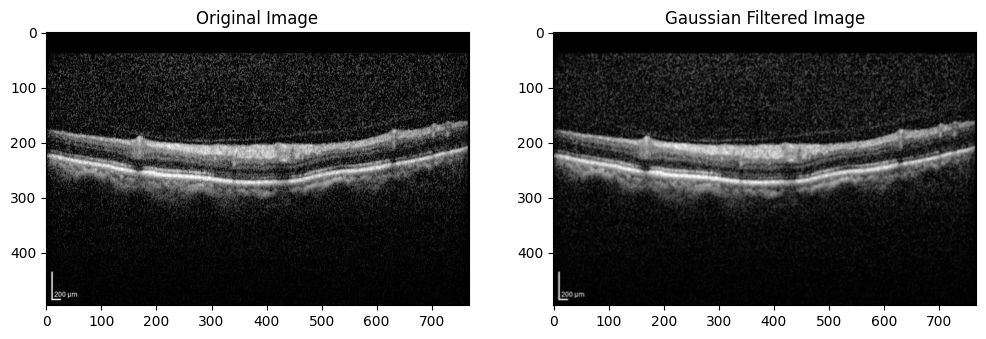

Directory /content/drive/MyDrive/drusenGaussianFil/012_Drusen.tif could not be accessed or does not exist.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Define your base directory and new directory for the filtered images
data_dir = '/content/drive/MyDrive/Eye/'
filtered_dir = '/content/drive/MyDrive/drusenGaussianFil'

# Create the filtered images directory if it doesn't already exist
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

for idx, entry in drusen.iterrows():
    img_path = os.path.join(data_dir, entry['Directory'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Apply Gaussian Blur
        filtered_img = cv2.GaussianBlur(img, (3, 3), 0)

        # Save the filtered image
        save_path = os.path.join(filtered_dir, os.path.basename(entry['Directory']))
        cv2.imwrite(save_path, filtered_img)

        # Optionally, show the first image's original and filtered version for verification
        if idx == 0:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(filtered_img, cmap='gray')
            plt.title('Gaussian Filtered Image')
            plt.show()
    else:
        print(f"Failed to load image at {img_path}")
else:
    print(f"Directory {save_path} could not be accessed or does not exist.")


In [ ]:
filtered_data_dir = '/content/drive/MyDrive/drusenGaussianFil'
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtered/'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in drusen.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

<ipython-input-4-e3534c49b49a>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


In [ ]:
# Assuming you have your target vector y as a pandas Series
y = drusen['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'NORMAL': 0, 'DRUSEN': 1})
X =hog_features

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.86875 0.8     0.78125 0.81875 0.78125]
Mean Accuracy: 0.8100000000000002


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.78125 0.69375 0.675   0.70625 0.65   ]
Mean Accuracy: 0.70125


Gamma: 0.001, Mean Accuracy: 0.7787499999999999
Gamma: 0.01, Mean Accuracy: 0.47624999999999995
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47000000000000003
Gamma: 10, Mean Accuracy: 0.47000000000000003


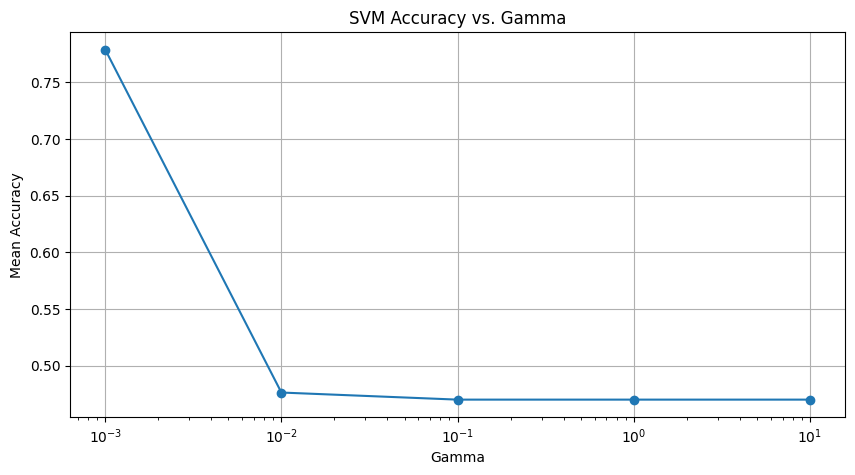

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.84375 0.71875 0.7625  0.76875 0.725  ]
Degree: 1, Mean Accuracy: 0.76375
Degree: 2, Cross-validation scores: [0.83125 0.75625 0.7875  0.8125  0.75   ]
Degree: 2, Mean Accuracy: 0.7875
Degree: 3, Cross-validation scores: [0.80625 0.71875 0.7875  0.7625  0.71875]
Degree: 3, Mean Accuracy: 0.75875
Degree: 4, Cross-validation scores: [0.75    0.68125 0.70625 0.5375  0.6625 ]
Degree: 4, Mean Accuracy: 0.6675000000000001
Degree: 5, Cross-validation scores: [0.58125 0.53125 0.55    0.46875 0.55625]
Degree: 5, Mean Accuracy: 0.5375


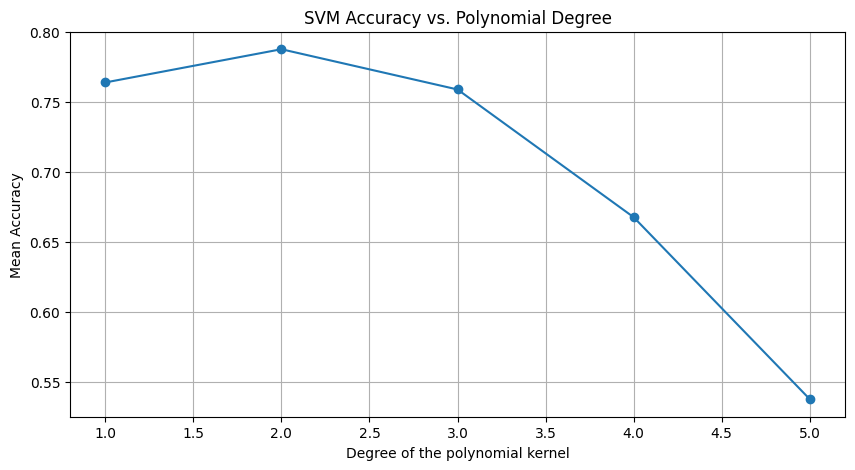

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores with Logistic Regression: [0.85625 0.79375 0.7875  0.8125  0.78125]
Mean Accuracy with Logistic Regression: 0.80625
Standard Deviation of Accuracy with Logistic Regression: 0.027099354235848493


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.7625  0.73125 0.7     0.76875 0.75625]
Mean Accuracy with KNN: 0.7437499999999999
Standard Deviation of Accuracy with KNN: 0.02531057091414575


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.575   0.49375 0.48125 0.60625 0.5625 ]
Mean Accuracy with Naive Bayes: 0.54375
Standard Deviation of Accuracy with Naive Bayes: 0.048250647664046936


In [ ]:
mport xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()









# **filetring**

In [ ]:
import cv2
import numpy as np
import os
from skimage import io  # Used for reading images if cv2 fails

# Define directories
data_dir = '/content/drive/MyDrive/Eye/'
save_dir = '/content/drive/MyDrive/drusenMultilevel'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to apply multilevel thresholding using k-means clustering
def multilevel_thresholding(image_path, k=3):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = io.imread(image_path, as_gray=True)  # Fallback using skimage
        if img is None:
            return None
        img = (img * 255).astype(np.uint8)  # skimage returns [0,1] float image

    # Reshape the image to a 2D array of pixels
    Z = img.reshape((-1, 1))

    # Convert to float
    Z = np.float32(Z)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back into uint8, and make original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((img.shape))

    return segmented_image

# Apply multilevel thresholding to each image in the sampled dataset
for idx, row in drusen.iterrows():
    image_path = os.path.join(data_dir, row['Directory'])
    result_image = multilevel_thresholding(image_path, k=3)  # Set k to the desired number of levels

    if result_image is not None:
        # Save the processed image
        save_path = os.path.join(save_dir, os.path.basename(row['Directory']))
        cv2.imwrite(save_path, result_image)
    else:
        print(f"Failed to load/process image: {row['Directory']}")

print("All images processed and saved to", save_dir)


All images processed and saved to /content/drive/MyDrive/drusenMultilevel


In [ ]:
filtered_data_dir ='/content/drive/MyDrive/drusenMultilevel'
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtered/'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in drusen.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

In [ ]:
# Assuming you have your target vector y as a pandas Series
y = drusen['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'NORMAL': 0, 'DRUSEN': 1})
X = hog_features

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.58125 0.54375 0.5125  0.55625 0.5125 ]
Mean Accuracy: 0.54125


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.6375  0.70625 0.4375  0.575   0.6    ]
Mean Accuracy: 0.59125


Degree: 1, Cross-validation scores: [0.56875 0.5375  0.5125  0.5625  0.4875 ]
Degree: 1, Mean Accuracy: 0.53375
Degree: 2, Cross-validation scores: [0.59375 0.5625  0.53125 0.575   0.51875]
Degree: 2, Mean Accuracy: 0.55625
Degree: 3, Cross-validation scores: [0.55625 0.55625 0.5     0.575   0.5    ]
Degree: 3, Mean Accuracy: 0.5375
Degree: 4, Cross-validation scores: [0.575   0.55625 0.5375  0.5875  0.53125]
Degree: 4, Mean Accuracy: 0.5575
Degree: 5, Cross-validation scores: [0.575   0.58125 0.55    0.60625 0.55   ]
Degree: 5, Mean Accuracy: 0.5725


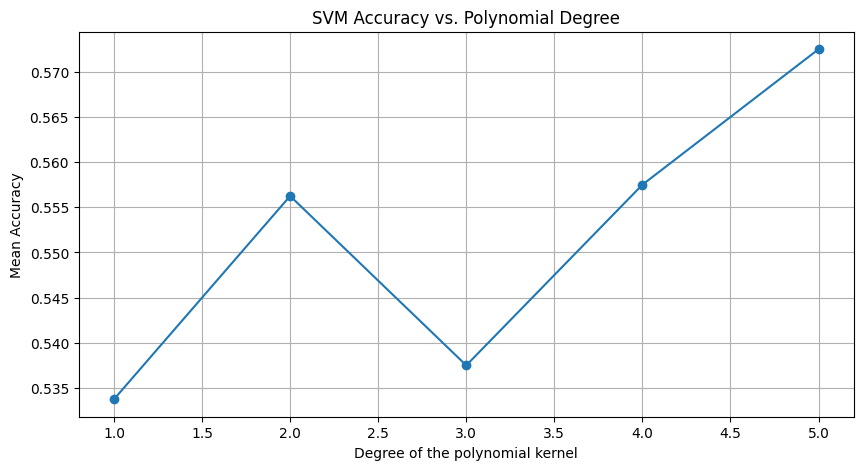

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

Gamma: 0.001, Mean Accuracy: 0.73125
Gamma: 0.01, Mean Accuracy: 0.8550000000000001
Gamma: 0.1, Mean Accuracy: 0.915
Gamma: 1, Mean Accuracy: 0.96875
Gamma: 10, Mean Accuracy: 0.96875


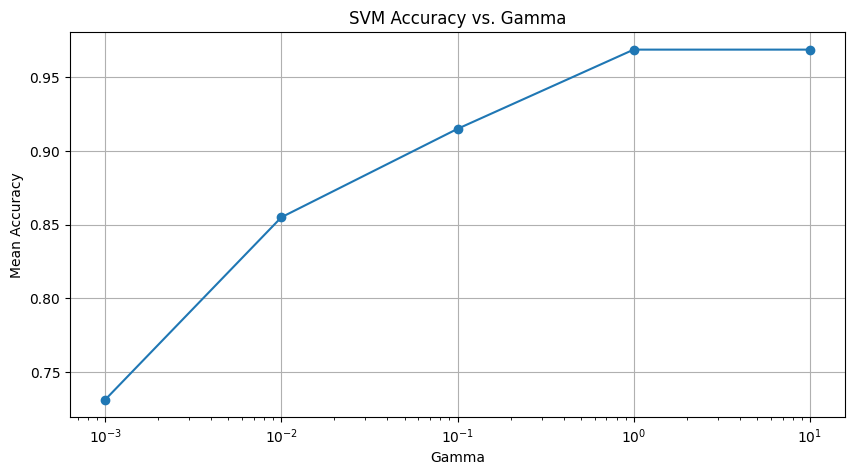

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.65625 0.5375  0.60625 0.63125 0.5625 ]
Mean Accuracy with Logistic Regression: 0.59875
Standard Deviation of Accuracy with Logistic Regression: 0.04355312847546086


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.925   0.9625  0.89375 0.925   0.95625]
Mean Accuracy with KNN: 0.9324999999999999
Standard Deviation of Accuracy with KNN: 0.024811791551599006


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.58125 0.55    0.5125  0.575   0.50625]
Mean Accuracy with Naive Bayes: 0.545
Standard Deviation of Accuracy with Naive Bayes: 0.030973779233409687


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.98125 0.9875  0.96875 1.      1.     ]
Mean Accuracy with XGBoost: 0.9875
Standard Deviation of Accuracy with XGBoost: 0.011858541225631427
